In [4]:
import torch
from model import *
from get_loader import get_loader
import torchvision.transforms as transforms
from PIL import Image
from IPython import display
import pandas as pd

In [9]:
def load_model_to_captioning(image_path="archive/images",
                             caption_path="archive/captions.txt",
                             checkpoint_path="my_checkpoint.pth.tar"):
    
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    
    test_loader, dataset = get_loader(
        root_folder=image_path,
        annotation_file=caption_path,
        transform=transform,
        num_workers=6,
    )
    
    device = "cuda"
    embedding_size = 256
    hidden_size = 256
    vocabulary_size = len(dataset.vocabulary)
    num_layers = 1
    model = CNNtoRNNTranslator(embedding_size, hidden_size, vocabulary_size, num_layers).to(device)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    
    return model, dataset.vocabulary, transform

In [10]:
def create_caption(image_path, model, vocabulary, transform, device="cuda", show_image=False):
    model.eval()
    image = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)
    word_list = model.image_caption(image.to(device), vocabulary)
    word_list = [word for word in word_list if not (word in [*vocabulary.stoi][:4])]
    caption = ' '.join([str(elem) for elem in word_list])
    if show_image:
        display.display(Image.open(image_path))
    return caption

In [11]:
model, vocab, transform = load_model_to_captioning(caption_path="archive/training_captions.txt",
                                                   checkpoint_path="my_checkpoint_100.pth.tar")

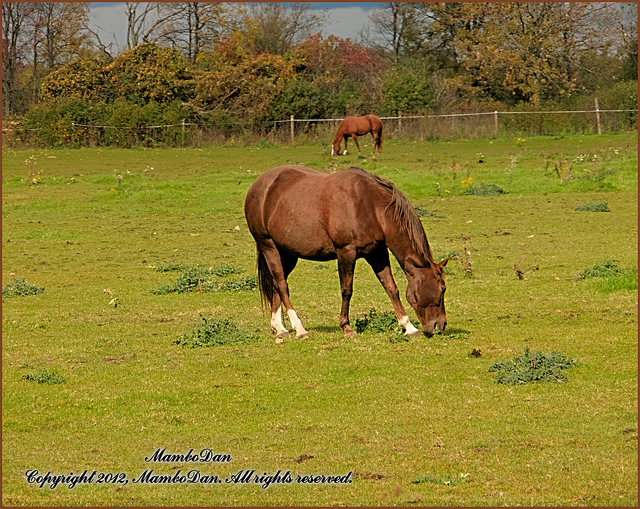

'a dog is jumping up at the beach .'

In [24]:
create_caption("test/images/10.jpg", model, vocab, transform, show_image=True)

In [3]:
train_image_path="archive/images"
train_caption_path="archive/captions.txt"

### Проверка качества

In [26]:
from sentence_transformers import SentenceTransformer
import numpy as np

In [27]:
def cosine_similarity(sentence_embeddings, ind_a, ind_b):
    s = sentence_embeddings
    return np.dot(s[ind_a], s[ind_b]) / (np.linalg.norm(s[ind_a]) * np.linalg.norm(s[ind_b]))

Sent_Trans_model = SentenceTransformer('bert-base-nli-mean-tokens')

s0 = "our president is a good leader he will not fail"
s1 = "our president is not a good leader he will fail"
s2 = "our president is a good leader"
s3 = "our president will succeed"

sentences = [s0, s1, s2, s3]

sentence_embeddings = Sent_Trans_model.encode(sentences)

s = sentence_embeddings

print(f"{s0} <--> {s1}: {cosine_similarity(sentence_embeddings, 0, 1)}")
print(f"{s0} <--> {s2}: {cosine_similarity(sentence_embeddings, 0, 2)}")
print(f"{s0} <--> {s3}: {cosine_similarity(sentence_embeddings, 0, 3)}")

our president is a good leader he will not fail <--> our president is not a good leader he will fail: 0.46340951323509216
our president is a good leader he will not fail <--> our president is a good leader: 0.8822923302650452
our president is a good leader he will not fail <--> our president will succeed: 0.7640182375907898


In [43]:
def check_quality(images_path="archive/images", captions_path="archive/captions.txt"):
    df = pd.read_csv(captions_path)
    quality = 0
    
    for elem in df.iterrows():
        image_name = elem[1][1]
        ans_caption = elem[1][2]
        out_caption = create_caption(images_path + "/" + str(image_name), model, vocab, transform)
        
        sentences = [out_caption, ans_caption]
        sentence_embeddings = Sent_Trans_model.encode(sentences)
        quality += cosine_similarity(sentence_embeddings, 0, 1)
        
    print("average quality: ", quality / df.shape[0])

In [42]:
df = pd.read_csv("archive/testing_captions.txt")
for elem in df.iterrows():
    image_name = elem[1][1]
    caption = elem[1][2]
    print(image_name)
    print(caption)
    break

<class 'str'>
A man and a woman kissing .


In [44]:
check_quality(captions_path="archive/testing_captions.txt")

average quality:  0.48605073826164913
